# AAIC Self Case Study 2
******

## Case Study Title: 'Dog Breed Identification' - Determine the breed of a dog in an image

### Introduction

Who's a good dog? Who likes ear scratches? Well, it seems those fancy deep neural networks don't have all the answers. However, maybe they can answer that ubiquitous question we all ask when meeting a four-legged stranger: what kind of good pup is that?

In this playground competition, we are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well we can tell that our Norfolk Terriers are different from our Norwich Terriers? With 120 breeds of dogs and a limited number of training images per class, the goal of the competition is to create a classifier capable of determining a dog's breed from a photo.


### Business Problem

Imagine a world where computers can process visual content better than humans. How easy our lives would be when AI could find our keys for us, and we would not need to spend precious minutes on a distressing search.

Computer vision, the field concerning machines being able to understand images and videos, is one of the hottest topics in the tech industry. At the core of computer vision is image recognition, the task of recognizing what an image represents. Here in this competition, we are digging a bit deeper. One such example can be not only identifying a dog from an image but also specifying its breed. 

We want to train our neural networks to such a level where it can perform fine-grained image categorization such that it will not only recognize the object from the image but also can tell its type (if any)


### ML formulation of the business problem

There are 120 breeds of dogs. So thus this problem becomes multi-class image classification


### Business Constraints

1.	Low latency- Low latency is one of the greatest requirements of this problem. No user will ever want to upload a picture and keep on waiting to get the answer.

2.	Probability scores: We want probability scores since we don’t want to just know the breed of the dog, but also with what probability a dog will belong to a particular breed.


### Metrics

1.	Multi-class log-loss: Since this is a problem of multi-class classification in images and we also require probabilities for each class, multi class log-loss needs to be used because log-loss penalizes small deviations in the probability scores.

2.	Multi-class confusion matrix: We can also plot the multi-class confusion matrix to know which classes are doing better and which aren’t.


### Datasets


Source: https://www.kaggle.com/competitions/dog-breed-identification/data


We are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs.

1.	Training data: 10,222 images of dogs.
2.	Test data: 10,357 images of dogs.


# Code:
-----

# Basic EDA

In [1]:
#checking if GPU is working or not
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [36]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5989746804949128921
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1385325979
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4654312589270696647
physical_device_desc: "device: 0, name: NVIDIA GeForce MX350, pci bus id: 0000:2b:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [1]:
#libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

from tensorflow.keras import applications
from tensorflow.keras.layers import Conv2D, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten,Input,Dropout
import random as rn
import cv2 
import os
from tqdm import tqdm

In [2]:
#loading the labels csv file

df=pd.read_csv("labels.csv")
print("shape: ",df.shape)

df.head(10)

shape:  (10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


<b> Checking the count/percentage of each breed

In [4]:
breed=df.breed.unique()
x=PrettyTable()
x.field_names=(['Breed','Count','Percentage(%)'])
for i in breed:
    a=len(df[df.breed==i])
    x.add_row([i,a,round(a/120*100)])

#using a prettytable to print the count of each breed in a sorted order
print(x.get_string(sortby="Count", reversesort=True))

+--------------------------------+-------+---------------+
|             Breed              | Count | Percentage(%) |
+--------------------------------+-------+---------------+
|       scottish_deerhound       |  126  |      105      |
|          maltese_dog           |  117  |       98      |
|          afghan_hound          |  116  |       97      |
|          entlebucher           |  115  |       96      |
|      bernese_mountain_dog      |  114  |       95      |
|            shih-tzu            |  112  |       93      |
|           pomeranian           |  111  |       92      |
|         great_pyrenees         |  111  |       92      |
|            basenji             |  110  |       92      |
|            samoyed             |  109  |       91      |
|        tibetan_terrier         |  107  |       89      |
|            airedale            |  107  |       89      |
|            leonberg            |  106  |       88      |
|             cairn              |  106  |       88     

Comment - So we see that our data containes 120 breeds, but it is slightly imbalanced because some breeds have lots of images and some have very few images. Out of 10.2k images, 'scottish_deerhound' contains the highest no. of images, ie, 126 (105%) whereas 'eskimo_dog' and 'briard' contains the least no. of images, ie, 66 (55%).

<b> Label encoding the breed names

In [3]:
df['label']=df.breed

In [4]:
le=LabelEncoder()

df.label=le.fit_transform(df.label)
df

,id,breed,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,18
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,35
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,3
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,75


In [7]:
#checking that there are 120 possible breeds or not
df['label'].unique()

array([ 19,  37,  85,  15,  49,  10,  18,   7,  97,  99, 113,  73,  79,
         2, 118,  89,  68,  21,  38,  83, 106,  58,  12,  26,   0,  67,
        55,  40, 114,  48,  54,  36, 110,  17, 109,  80, 100,  57,  66,
        46,  53,   8,   6,  95,  90,  56,   5,  14,  94,  77,  24,  63,
        84,  16,  42,  33,  71, 115,  29,  93,  88,  72,  65,   3,  69,
        74,  25,  11,   4,  70,  27,  60,  31,  96,   1,  82,  92,  75,
        43,  59,  22, 111,  30,  44,  81, 103, 104,  39,  50, 101,  78,
        23,  28,  35,  52,   9, 112, 116,  64, 117,  98, 105,  62,  61,
        76,  87,  34, 119,  86,  51,  13, 102, 107,  47,  45,  20, 108,
        41,  32,  91])

In [5]:
#getting the actual path for a particular image as its id

for i,data in df.iterrows():
    df.at[i,'id']='train/'+data['id']+'.jpg'
    
df.head()

,id,breed,label
0,train/000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull,19
1,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo,37
2,train/001cdf01b096e06d78e9e5112d419397.jpg,pekinese,85
3,train/00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick,15
4,train/0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,49


<b> Printing a few dog images to check everything is working fine

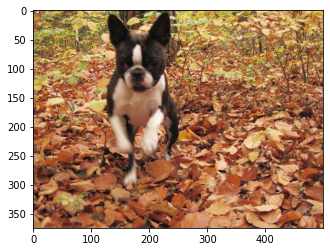

In [9]:
img_path=df.id[0]    #0th image
im=Image.open(img_path)
plt.imshow(im)

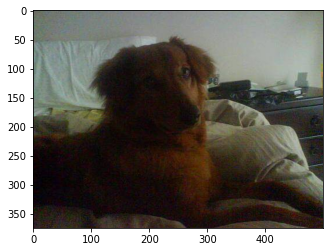

In [10]:
img_path=df.id[1000]     #1000th image
im=Image.open(img_path)
plt.imshow(im)

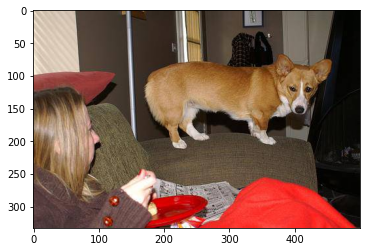

In [11]:
img_path=df.id[10000]     #10000th image
im=Image.open(img_path)
plt.imshow(im)

<b> Getting the widths and heights of the training images

In [7]:
for i,data in df.iterrows():
    df.at[i,'width']=Image.open(data['id']).width
    df.at[i,'height']=Image.open(data['id']).height
    
df.head()

,id,breed,label,width,height
0,train/000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull,19,500.0,375.0
1,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo,37,500.0,375.0
2,train/001cdf01b096e06d78e9e5112d419397.jpg,pekinese,85,500.0,375.0
3,train/00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick,15,400.0,344.0
4,train/0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,49,500.0,500.0


<b> Plotting the pdfs of heights and weights of the training images

Text(0.5, 1.0, 'Pdf of widths of images')

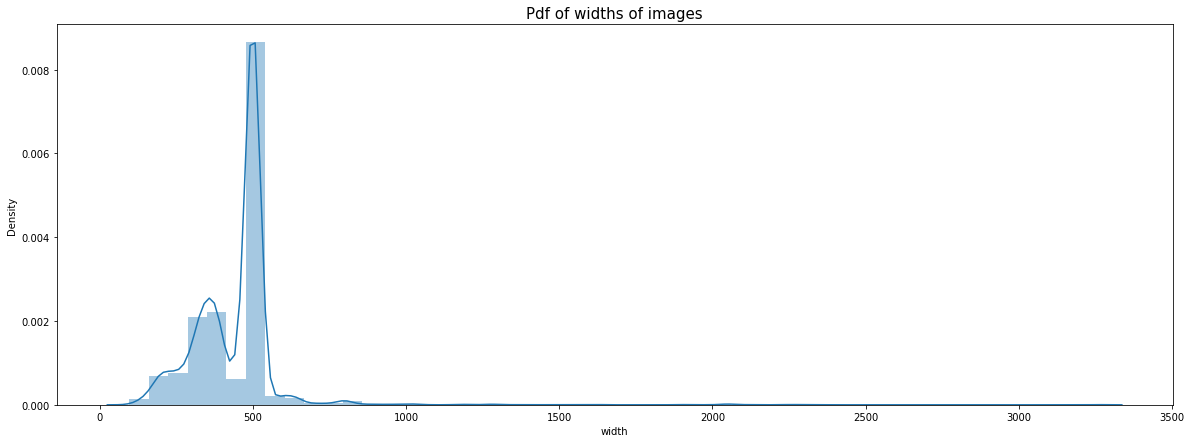

In [30]:
plt.figure(figsize=(20,7))
sns.distplot(df.width)
plt.title("Pdf of widths of images",fontsize=15)

Comment- We see that most of the training images have a width of 500. We can also notice that a considerable number of images have their width in the range of 300-400. A few images also have a width of more than 3000.

Text(0.5, 1.0, 'Pdf of heights of images')

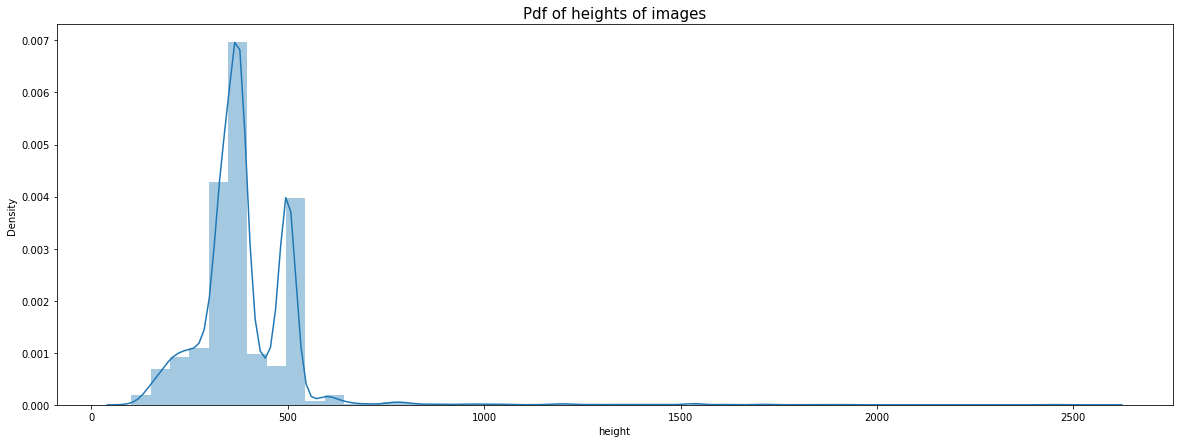

In [31]:
plt.figure(figsize=(20,7))
sns.distplot(df.height)
plt.title("Pdf of heights of images",fontsize=15)

Comment- Most of the training images have a height in the range of 300-550. A few images also have width of more than 2500.

#### Printing randomly chosen 25 images.

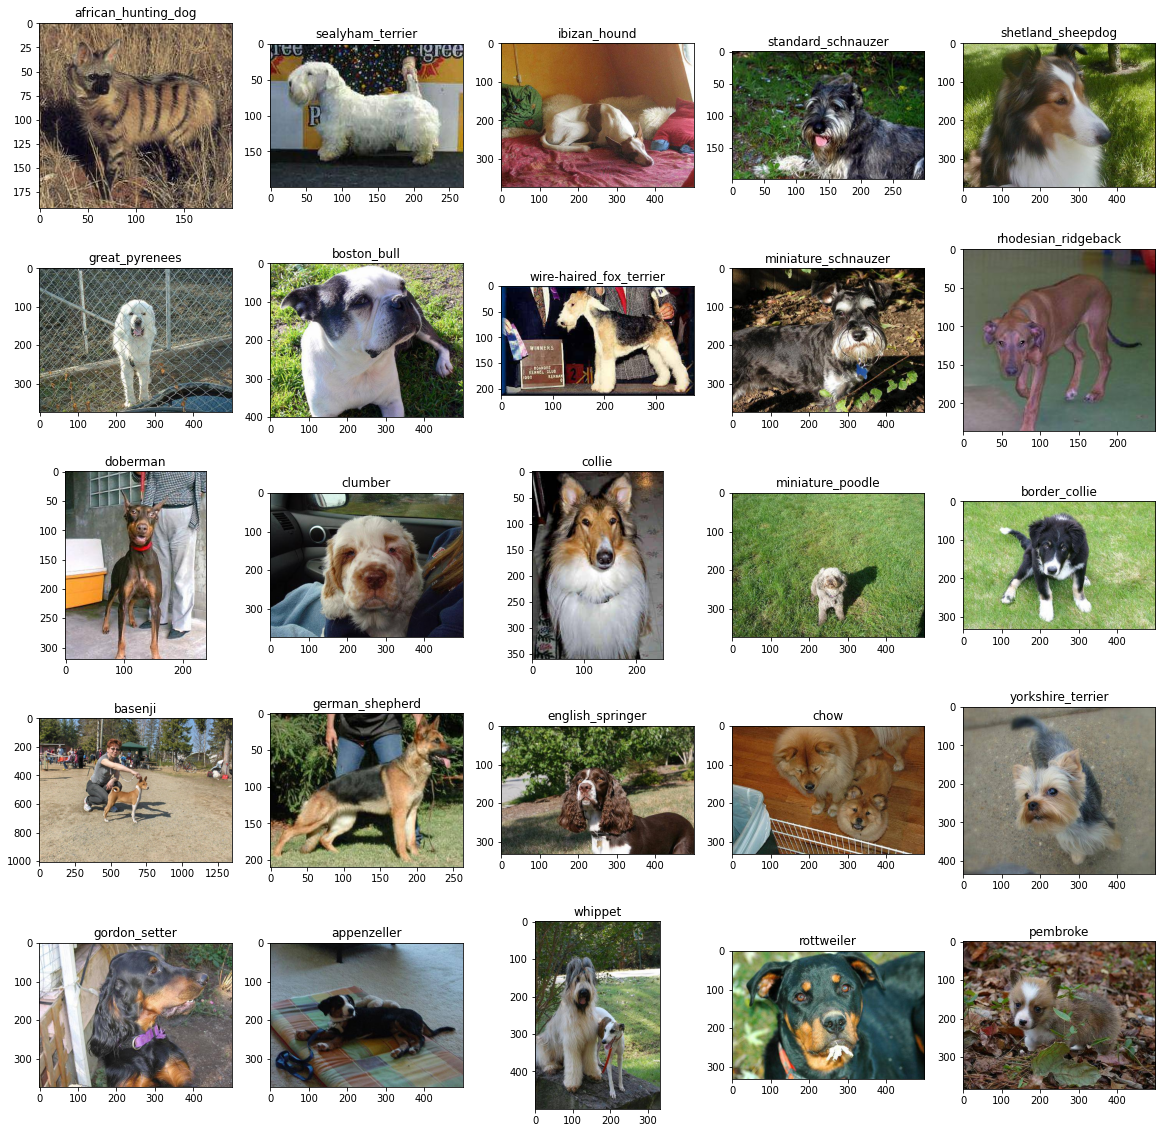

In [6]:
indices=np.random.choice(range(len(df)),25,replace=False)
c=1
plt.figure(figsize=(20,20))
for i in indices:
    plt.subplot(5,5,c)
    image = cv2.imread(df.id[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title(df.breed[i])
    plt.imshow(image)
    c+=1